In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
from itertools import chain, combinations
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols,gls,wls
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

In [3]:
import time
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    return str(time.time() - startTime_for_tictoc) 

tic()
time.sleep(1)
print(toc())

1.0011756420135498


In [4]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, layer_dim,startZero=False,dropout=0.0):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        if dropout==0.0:
            self.rnn = nn.RNN(1, hidden_dim, layer_dim, batch_first=True, 
                          nonlinearity='tanh')   
        else:
            self.rnn = nn.RNN(1, hidden_dim, layer_dim, batch_first=True, 
              nonlinearity='tanh',dropout=dropout)   

        # Readout layer
        self.fc = nn.Linear(hidden_dim, 1)
        
        if startZero:
            self.rnn.weight_ih_l0.data.fill_(0.0)
            self.rnn.weight_hh_l0.data.fill_(0.0)
            self.rnn.bias_ih_l0.data.fill_(0.0)
            self.rnn.bias_hh_l0.data.fill_(0.0)
            self.fc.weight.data.fill_(0.0)
            self.fc.bias.data.fill_(0.0)
        #you could use a softmax instead of a hidden layer
        #self.fc = nn.Softmax(hidden_dim, output_dim)
    
    def resetToZero(self,nrOfBatches):
        self.h0 = Variable(torch.zeros(self.layer_dim, nrOfBatches, self.hidden_dim))
        
    def forward(self, x):
            
        # One time step
        interOut, self.h0 = self.rnn(x,self.h0)
        out = self.fc(interOut[-1,:,:])
        return out,interOut

    def retreiveAllHistory(self,x):
        self.resetToZero(1)
        o,h=self.forward(x)
        return h.detach().numpy().reshape((x.size(1),self.hidden_dim))
        
    def retreiveAllActionsWithNoise(self,x,nodes,theVar):
        self.resetToZero(1)
        h=self.h0
        actions=[]
        for i in range(x.size(1)):
            for node in nodes:
                h[0][0][node]+=numpy.random.normal(0.0,theVar)
                
            interOut,h=self.rnn(torch.tensor([[[float(x[0][i][0])]]]),h)
            out = self.fc(interOut[-1,:,:])
            actions.append(float(out.data[0][0]))
        return actions

    def retreiveAllActionsWithNoiseAtTimePoints(self,x,nodes,theVar,timePoints):
        self.resetToZero(1)
        h=self.h0
        actions=[]
        tp=0
        for i in range(x.size(1)):
            if tp in timePoints:
                print("noised at",tp)
                for node in nodes:
                    h[0][0][node]+=numpy.random.normal(0.0,theVar)
            tp+=1  
            interOut,h=self.rnn(torch.tensor([[[float(x[0][i][0])]]]),h)
            out = self.fc(interOut[-1,:,:])
            actions.append(float(out.data[0][0]))
        return actions
    
myRNN=RNNModel(8,1)
myRNN.resetToZero(1)
signals=1.0*(numpy.random.random((1,256,1))>0.5)
signals=torch.tensor(signals)
print("signals",signals.shape)
O,H=myRNN(signals.float())
print(O.shape,H.shape)
myRNN.resetToZero(1)

actions=myRNN.retreiveAllActionsWithNoise(signals,[0,2,7],0.0)
print(actions[:5])


signals torch.Size([1, 256, 1])
torch.Size([256, 1]) torch.Size([1, 256, 8])
[0.3004559576511383, 0.3153121769428253, 0.3143875300884247, 0.3062821328639984, 0.28343117237091064]


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, layer_dim):
        super(LSTMModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
                
        self.lstm = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True) 

        # Readout layer
        self.fc = nn.Linear(hidden_dim, 1)
        
    
    def resetToZero(self,nrOfBatches):
        self.h0 = (torch.zeros(1,nrOfBatches,self.hidden_dim),
                    torch.zeros(1,nrOfBatches,self.hidden_dim))
        
        
    def forward(self, x):
            
        # One time step
        interOut, self.h0 = self.lstm(x,self.h0)
        out = self.fc(interOut[-1,:,:])
        return out,self.h0

    def retreiveAllHistory(self,x):
        self.resetToZero(1)
        H,C=self.h0
        history=[]
        for i in range(x.size(1)):
            interOut,(H,C)=self.lstm(torch.tensor([[[x[0][i]]]]).float(),(H,C))
            history.append(H.tolist()[0][0]+C.tolist()[0][0])
        return history

    def retreiveAllActionsWithNoise(self,x,nodes,theVar):
        self.resetToZero(1)
        H,C=self.h0
        actions=[]
        for i in range(x.size(1)):
            for node in nodes:
                if node>=self.hidden_dim:
                    H[0][0][node-self.hidden_dim]+=numpy.random.normal(0.0,theVar)
                else:
                    C[0][0][node]+=numpy.random.normal(0.0,theVar)
                    
            interOut,(H,C)=self.lstm(torch.tensor([[[x[0][i]]]]).float(),(H,C))
            out = self.fc(interOut[-1,:,:])
            actions.append(float(out.data[0][0]))
        return actions

myLSTM=LSTMModel(4,1)
myLSTM.resetToZero(1)
signals=1.0*(numpy.random.random((1,256,1))>0.5)
signals=torch.tensor(signals)
O,H=myLSTM(signals.float())
print(O.shape,H)

history=myLSTM.retreiveAllHistory(signals)

myLSTM.resetToZero(1)

actions=myLSTM.retreiveAllActionsWithNoise(signals,[0,2,6],0.0)

torch.Size([256, 1]) (tensor([[[-0.2753,  0.2292,  0.3981, -0.0367]]], grad_fn=<StackBackward>), tensor([[[-0.4859,  0.6767,  0.9711, -0.1190]]], grad_fn=<StackBackward>))


In [7]:
class GRUModel(nn.Module):
    def __init__(self, hidden_dim, layer_dim,dropout=0.0):
        super(GRUModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        if dropout==0.0:
            self.gru = nn.GRU(1, hidden_dim, layer_dim, batch_first=True)   
        else:
            self.gru = nn.GRU(1, hidden_dim, layer_dim, batch_first=True)   

        # Readout layer
        self.fc = nn.Linear(hidden_dim, 1)
        
    
    def resetToZero(self,nrOfBatches):
        self.h0 = Variable(torch.zeros(self.layer_dim, nrOfBatches, self.hidden_dim))
        
    def forward(self, x):
            
        # One time step
        interOut, self.h0 = self.gru(x,self.h0)
        out = self.fc(interOut[-1,:,:])
        return out,interOut
    
    def retreiveAllHistory(self,x):
        self.resetToZero(1)
        o,h=self.forward(x)
        return h.detach().numpy().reshape((x.size(1),self.hidden_dim))

    def retreiveAllActionsWithNoise(self,x,nodes,theVar):
        self.resetToZero(1)
        h=self.h0
        actions=[]
        for i in range(x.size(1)):
            for node in nodes:
                h[0][0][node]+=numpy.random.normal(0.0,theVar)
                
            interOut,h=self.gru(torch.tensor([[[float(x[0][i][0])]]]),h)
            out = self.fc(interOut[-1,:,:])
            actions.append(float(out.data[0][0]))
        return actions
        
myGRU=GRUModel(8,1)
myGRU.resetToZero(1)
signals=1.0*(numpy.random.random((1,256,1))>0.5)
signals=torch.tensor(signals)
O,H=myGRU(signals.float())
print(O.shape,H.shape)


torch.Size([256, 1]) torch.Size([1, 256, 8])


In [ ]:
myRNN=RNNModel(6,1,startZero=False)
optimizer = optim.Adam(myRNN.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

episodes=2000

nBack=5
L=[]
C=[]
tic()
for episode in range(episodes):
    base=list(1.0*(numpy.random.random((256))>0.5))
    signals=numpy.array(base).reshape((1,256,1))
    target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
    signals=torch.tensor(signals)
    target=torch.tensor(target)
    optimizer.zero_grad()
    myRNN.resetToZero(1)
    outputs,history = myRNN(signals.float())
    loss = error(outputs, target.float())
    L.append(float(loss))
    loss.backward()
    optimizer.step()
    if episode%100 ==0:
        print(episode,L[-1])
    o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
    t=target.detach().numpy().reshape((256))
    c=abs(o-t).sum()/256
    C.append(c)
plot(L,'k')
plot(C)
print(toc())

torch.save(myRNN.state_dict(), "RNN_example_{0}back_{1}nodes.model".format(nBack,6))
#myRNN=RNNModel(6,1,startZero=False)

In [ ]:
myLSTM=LSTMModel(5,1)
optimizer = optim.Adam(myLSTM.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

episodes=2000

nBack=5
L=[]
C=[]
tic()
for episode in range(episodes):
    base=list(1.0*(numpy.random.random((256))>0.5))
    signals=numpy.array(base).reshape((1,256,1))
    target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
    signals=torch.tensor(signals)
    target=torch.tensor(target)
    optimizer.zero_grad()
    myLSTM.resetToZero(1)
    outputs,history = myLSTM(signals.float())
    loss = error(outputs, target.float())
    L.append(float(loss))
    loss.backward()
    optimizer.step()
    if episode%100 ==0:
        print(episode,L[-1])
    o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
    t=target.detach().numpy().reshape((256))
    c=abs(o-t).sum()/256
    C.append(c)
plot(L,'k')
plot(C)
print(toc())

torch.save(myLSTM.state_dict(), "LSTM_example_{0}back_{1}nodes.model".format(nBack,5))


In [ ]:
myGRU=GRUModel(6,1)
optimizer = optim.Adam(myGRU.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

episodes=2000

nBack=5
L=[]
C=[]
tic()
for episode in range(episodes):
    base=list(1.0*(numpy.random.random((256))>0.5))
    signals=numpy.array(base).reshape((1,256,1))
    target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
    signals=torch.tensor(signals)
    target=torch.tensor(target)
    optimizer.zero_grad()
    myGRU.resetToZero(1)
    outputs,history = myGRU(signals.float())
    loss = error(outputs, target.float())
    L.append(float(loss))
    loss.backward()
    optimizer.step()
    if episode%100 ==0:
        print(episode,L[-1])
    o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
    t=target.detach().numpy().reshape((256))
    c=abs(o-t).sum()/256
    C.append(c)
plot(L,'k')
plot(C)
print(toc())

torch.save(myGRU.state_dict(), "GRU_example_{0}back_{1}nodes.model".format(nBack,6))


In [8]:
def powerset(iterable):
    return list(chain.from_iterable(combinations(iterable, r) for r in range(len(iterable)+1)))

def computeSymbolCount(randomVariable):
    collector=dict()
    quantile=1.0/len(randomVariable)
    for element in randomVariable:
        if element not in collector:
            collector[element]=0.0
        collector[element]+=quantile
    return collector

def computeEntropy(symbolCount):
    H=0.0
    for it in symbolCount:
        p=symbolCount[it]
        if p>0.0:
            H+=p*log2(p)
    return -1.0*H

def normalizeSymbolCount(symbolCount):
    theSum=sum(symbolCount.values())
    for s in symbolCount:
        symbolCount[s]/=theSum
    return symbolCount

def extractBitPattern(measurements,bitPattern):
    ret=list()
    for row in measurements:
        value=0
        for i in bitPattern:
            value+=int(row[i])<<i
        ret.append(value)
    return ret

def computeR(world,brain,sensors):
    sensorBrainRV=joinRandomVariables(sensors, brain)
    sensorWorldRV=joinRandomVariables(sensors, world)
    worldSensorBrainRV=joinRandomVariables(sensorWorldRV, brain)
    sensorPD=computeSymbolCount(sensors)
    sensorBrainPD=computeSymbolCount(sensorBrainRV)
    sensorWorldPD=computeSymbolCount(sensorWorldRV)
    worldSensorBrainPD=computeSymbolCount(worldSensorBrainRV)
    #print("WS",computeEntropy(worldSensorPD),"+WH",computeEntropy(worldBrainPD),"-S",computeEntropy(sensorPD),"-WHS",computeEntropy(worldSensorBrainPD))
    return computeEntropy(sensorBrainPD)+computeEntropy(sensorWorldPD)-computeEntropy(sensorPD)-computeEntropy(worldSensorBrainPD)


def medianBinarization(data):
    medians=list()
    T=transpose(data)
    for m in T:
        medians.append(median(m))
    for t in range(len(T)):
        l=numpy.array(T[t])
        T[t]=list((l>=medians[t])*1.0)
    return transpose(T)

def medianBinarizationVector(data):
    d=numpy.array(data)
    m=median(d)
    return 1.0*(d>m)
    
def joinRandomVariables(R1,R2):
    ret=list()
    for i in range(len(R1)):
        ret.append(R1[i]+R2[i])
    return ret

def computePermutationMatrix(data,worldNodes,brainNodes,sensorNodes):
    permutations=powerset(brainNodes)[1:]
    M=numpy.zeros((len(permutations),len(worldNodes)))
    bitPatternsWorld=list()
    bitPatternsBrain=list()
    bitPatternsSensor=extractBitPattern(data,sensorNodes)
    for p in range(len(permutations)):
        perm=permutations[p]
        bitPatternsBrain.append(extractBitPattern(data,perm))
        
    for w in range(len(worldNodes)):
        wn=[w]
        bitPatternsWorld.append(extractBitPattern(data,wn))
    for p in range(len(permutations)):
        for w in range(len(worldNodes)):
            M[p][w]=computeR(bitPatternsWorld[w],bitPatternsBrain[p],bitPatternsSensor)
    D=DataFrame()
    D["partition"]=permutations
    for w in range(len(worldNodes)):
        D["R{0}".format(w)]=M.transpose()[w]
    return D
medianBinarization([[1,2,3],[1,2,3],[0,0,0],[0,0,4]])

array([[1, 1, 1],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 1]])

In [9]:
def makePerfectData(n,nrOfDataPoints):
    base=list(1.0*(numpy.random.random((nrOfDataPoints+n))>0.5))
    M=[]
    for i in range(n,nrOfDataPoints+n):
        row=[base[i]]
        for j in range(n):
            row.append(base[i-j])
        row.append(base[i])
        M.append(row)
    return M


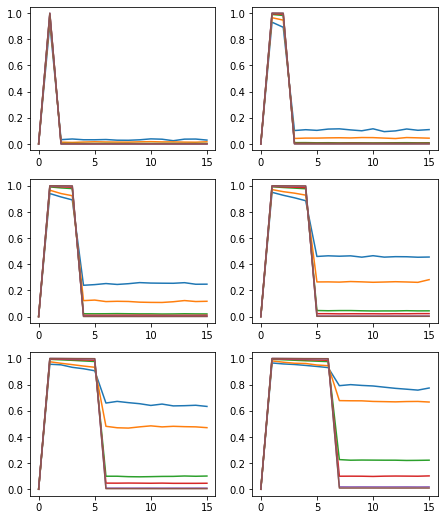

In [13]:
collector=dict()
for n in [2,3,4,5,6,7]:
    for np in [50,100,500,1000,5000,10000]:
        Y=list()
        for rep in range(100):
            M=makePerfectData(n,np)
            W=extractBitPattern(M,[0])
            H=extractBitPattern(M,range(1,n+1))
            S=extractBitPattern(M,[n+1])

            Ht=[]
            for t in range(16):
                if t==0:
                    NW=W
                else:
                    NW=[0]*t+W[:-t]
                y=computeR(NW,H,S)
                Ht.append(y)
            Y.append(Ht)
        Y=numpy.array(Y)
        collector["{0} {1}".format(n,np)]=Y

figure(figsize=[7.3,9])
for n in [2,3,4,5,6,7]:
    subplot(3,2,n-1)
    for np in [50,100,500,1000,5000,10000]:
        plot(collector["{0} {1}".format(n,np)].mean(0))

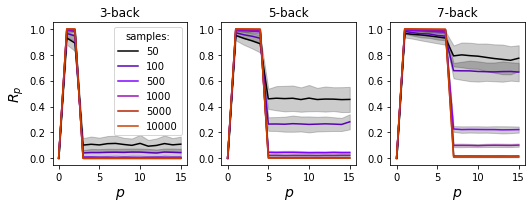

In [14]:
figure(figsize=[7.5,3])
nps=[50,100,500,1000,5000,10000]
my_cmap = get_cmap('gnuplot')
where=1
for n in [3,5,7]:
    subplot(1,3,where)
    where+=1
    for np in nps:
        m=collector["{0} {1}".format(n,np)].mean(0)
        e=collector["{0} {1}".format(n,np)].std(0)
        v=float(nps.index(np))/8.0
        plot(m,color=my_cmap(v),label=str(np))
        fill_between(range(len(e)),m-e,m+e,alpha=0.2,color="k")
    if n==3:
        legend(title="samples:")
        ylabel(r"$R_{p}$",fontsize=14)
    xlabel(r"$p$",fontsize=14)
    title("{0}-back".format(n))
tight_layout()
savefig("R_p_sampleSize.pdf")

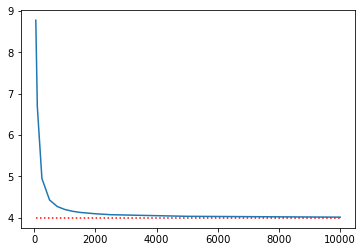

In [15]:
collectorSum=dict()
n=5
nps=[50,100,250,500,750,1000,1250,1500,2000,2500,5000,10000]
ms=[]
for np in nps :
    Y=list()
    for rep in range(100):
        M=makePerfectData(n,np)
        W=extractBitPattern(M,[0])
        H=extractBitPattern(M,range(1,n+1))
        S=extractBitPattern(M,[n+1])

        Ht=[]
        for t in range(16):
            if t==0:
                NW=W
            else:
                NW=[0]*t+W[:-t]
            y=computeR(NW,H,S)
            Ht.append(y)
        Y.append(sum(Ht))
    Y=numpy.array(Y)
    collectorSum["{0} {1}".format(n,np)]=Y
    ms.append(Y.mean())
plot(nps,ms)
plot(nps,[4.0]*len(nps),':r')

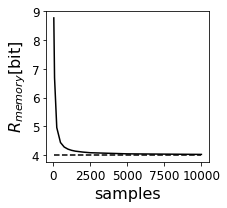

In [16]:
figure(figsize=[3.25,3])
plot(nps,ms,'k')
plot(nps,[4.0]*len(nps),'--k')
xlabel("samples",fontsize=16)
ylabel(r"$R_{memory}$[bit]",fontsize=16)
xticks([0,2500,5000,7500,10000],['0','2500','5000','7500','10000'],fontsize=12)
yticks(fontsize=12)
tight_layout()
savefig("Rmemory_samples.pdf")

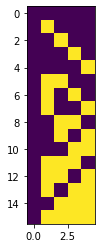

In [17]:
n=5
np=10000
M=makePerfectData(n,np)
hiddenPS=powerset([2,3,4,5])
resM=numpy.zeros((16,5))
W=extractBitPattern(M,[0])

for w in range(5):
    for h in hiddenPS:
        H=extractBitPattern(M,list(h))
        S=extractBitPattern(M,[n+1])
        if w==0:
            NW=W
        else:
            NW=[0]*w+W[:-w]
        resM[hiddenPS.index(h)][w]=computeR(NW,H,S)
imshow(resM)

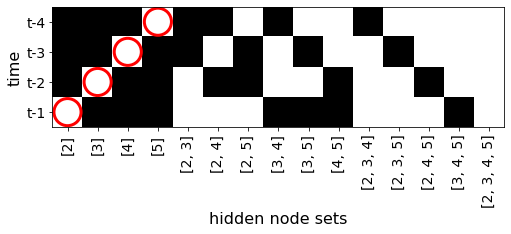

In [18]:
XL=[]
for i in range(1,16):
    XL.append(str(list(hiddenPS[i])))
figure(figsize=[7.5,3])
imshow(resM.transpose(),cmap='gray')
ylim(0.5,4.5)
xlim(0.5,15.5)
yticks([1,2,3,4],['t-1','t-2','t-3','t-4'],fontsize=14)
xticks(range(1,16),XL,rotation=90,fontsize=14)
xlabel("hidden node sets",fontsize=16)
ylabel("time",fontsize=16)
gca().add_patch(Circle((1.0,1.0),0.45,color='r',fill=False,linewidth=3))
gca().add_patch(Circle((2.0,2.0),0.45,color='r',fill=False,linewidth=3))
gca().add_patch(Circle((3.0,3.0),0.45,color='r',fill=False,linewidth=3))
gca().add_patch(Circle((4.0,4.0),0.45,color='r',fill=False,linewidth=3))
tight_layout()
savefig("partitionsToPast.pdf")

In [19]:
def jointInformation(x,y):
    eX=computeEntropy(computeSymbolCount(x))
    eY=computeEntropy(computeSymbolCount(y))
    jXY=joinRandomVariables(x,y)
    eXY=computeEntropy(computeSymbolCount(jXY))
    return eX+eY-eXY,eX,eY,eXY

In [ ]:
jointInformation(list(numpy.random.choice([0,1],1000)),list(numpy.random.choice([0,2],1000)))

In [25]:
### no need to rerun the following cell

In [ ]:
nBack=5
perf=[]
for n in [1,2,3,4,5,6,7,8,9,10]:
    Y=[]
    for rep in range(10):
        myRNN=RNNModel(n,1,startZero=False)
        optimizer = optim.Adam(myRNN.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
        error = nn.MSELoss()
        episodes=2000

        L=[]
        C=[]
        tic()
        for episode in range(episodes):
            base=list(1.0*(numpy.random.random((256))>0.5))
            signals=numpy.array(base).reshape((1,256,1))
            target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
            signals=torch.tensor(signals)
            target=torch.tensor(target)
            optimizer.zero_grad()
            myRNN.resetToZero(1)
            outputs,history = myRNN(signals.float())
            loss = error(outputs, target.float())
            loss.backward()
            optimizer.step()
            
            o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
            t=target.detach().numpy().reshape((256))
            c=abs(o-t).sum()/256
            C.append(c)
        r=mean(C[-10:])
        Y.append(r)
        print(n,rep,r,toc())
        torch.save(myRNN.state_dict(), "RNN_sizeCheck_{0}_{1}.model".format(n,rep))
        
    perf.append(Y)

In [22]:
#save the above, but no need to run, files are already here
#pickle.dump( numpy.array(perf), open( "saveRNNoptimizationDataSECOND.p", "wb" ) )
#however, you might want to load the files:
perf=pickle.load( open( "saveRNNoptimizationData.p", "rb" ) )

<Figure size 432x288 with 0 Axes>

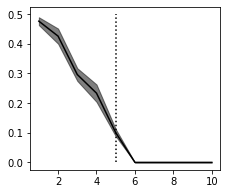

<Figure size 432x288 with 0 Axes>

In [24]:
resRNNs=numpy.array(perf)
figure(figsize=[7.5,3])
x=[1,2,3,4,5,6,7,8,9,10]

subplot(1,2,1)
m=resRNNs.mean(1)
d=resRNNs.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.5,color='k')
plot(x,m,'k')
plot([5,5],[0,0.5],':k')
figure()


In [ ]:
history.shape

### no need to rerun the following cell

In [ ]:
nBack=5
#perfLSTM=[]
for n in [7,8,9,10]:#[1,2,3,4,5,6]:
    Y=[]
    for rep in range(10):
        myLSTM=LSTMModel(n,1)
        optimizer = optim.Adam(myLSTM.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
        error = nn.MSELoss()
        episodes=2000

        L=[]
        C=[]
        tic()
        for episode in range(episodes):
            base=list(1.0*(numpy.random.random((256))>0.5))
            signals=numpy.array(base).reshape((1,256,1))
            target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
            signals=torch.tensor(signals)
            target=torch.tensor(target)
            optimizer.zero_grad()
            myLSTM.resetToZero(1)
            outputs,history = myLSTM(signals.float())
            loss = error(outputs, target.float())
            loss.backward()
            optimizer.step()
            
            o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
            t=target.detach().numpy().reshape((256))
            c=abs(o-t).sum()/256
            C.append(c)
        r=mean(C[-10:])
        Y.append(r)
        print(n,rep,r,toc())
    perfLSTM.append(Y)

In [27]:
pL=pickle.load( open( "saveLSTMoptimizationData.p", "rb" ) )

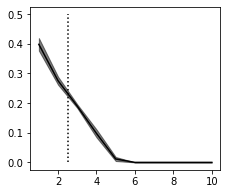

In [28]:
#pL=numpy.array(perfLSTM)
figure(figsize=[7.5,3])
x=[1,2,3,4,5,6,7,8,9,10]

subplot(1,2,2)
m=pL.mean(1)
d=pL.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.5,color='k')
plot(x,m,'k')
plot([2.5,2.5],[0,0.5],':k')


### no need to rerun the following cell 

In [ ]:
nBack=5
perfGRU=[]
for n in [1,2,3,4,5,6,7,8,9,10]:#[
    Y=[]
    for rep in range(10):
        myGRU=GRUModel(n,1)
        optimizer = optim.Adam(myGRU.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
        error = nn.MSELoss()
        episodes=2000

        L=[]
        C=[]
        tic()
        for episode in range(episodes):
            base=list(1.0*(numpy.random.random((256))>0.5))
            signals=numpy.array(base).reshape((1,256,1))
            target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
            signals=torch.tensor(signals)
            target=torch.tensor(target)
            optimizer.zero_grad()
            myGRU.resetToZero(1)
            outputs,history = myGRU(signals.float())
            loss = error(outputs, target.float())
            loss.backward()
            optimizer.step()
            
            o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
            t=target.detach().numpy().reshape((256))
            c=abs(o-t).sum()/256
            C.append(c)
        r=mean(C[-10:])
        Y.append(r)
        print(n,rep,r,toc())
    perfGRU.append(Y)

In [29]:
pG=pickle.load( open( "saveGRUoptimizationData.p", "rb" ) )

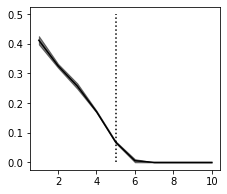

In [30]:
#pG=numpy.array(perfGRU)
figure(figsize=[7.5,3])
x=[1,2,3,4,5,6,7,8,9,10]

subplot(1,2,2)
m=pG.mean(1)
d=pG.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.5,color='k')
plot(x,m,'k')
plot([5,5],[0,0.5],':k')


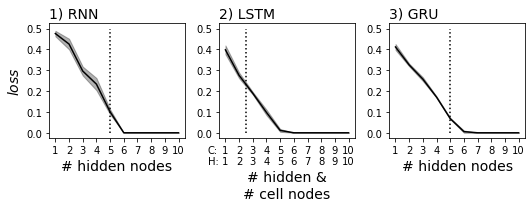

In [31]:
figure(figsize=[7.5,3])
x=[1,2,3,4,5,6,7,8,9,10]

subplot(1,3,1)
m=resRNNs.mean(1)
d=resRNNs.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.3,color='k')
plot(x,m,'k')
plot([5,5],[0,0.5],':k')
title("1) RNN",fontsize=14,loc='left')
xticks([1,2,3,4,5,6,7,8,9,10],["1","2","3","4","5","6","7","8","9","10"])
xlabel("# hidden nodes",fontsize=14)
yticks([0,0.1,0.2,0.3,0.4,0.5])
ylabel(r"$loss$",fontsize=14)

subplot(1,3,2)
m=pL.mean(1)
d=pL.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.3,color='k')
plot(x,m,'k')
plot([2.5,2.5],[0,0.5],':k')
title("2) LSTM",fontsize=14,loc='left')
xticks([1,2,3,4,5,6,7,8,9,10],["1\n1","2\n2","3\n3","4\n4","5\n5","6\n6","7\n7","8\n8","9\n9","10\n10"])
xlabel("# hidden &\n# cell nodes",fontsize=14)
yticks([0,0.1,0.2,0.3,0.4,0.5])
text(-0.3,-0.1,"C:",fontsize=10)
text(-0.3,-0.15,"H:",fontsize=10)
subplot(1,3,3)
m=pG.mean(1)
d=pG.std(1)/sqrt(10.0)
fill_between(x,m-d,m+d,alpha=0.3,color='k')
plot(x,m,'k')
plot([5,5],[0,0.5],':k')
title("3) GRU",fontsize=14,loc='left')
xticks([1,2,3,4,5,6,7,8,9,10],["1","2","3","4","5","6","7","8","9","10"])
xlabel("# hidden nodes",fontsize=14)
yticks([0,0.1,0.2,0.3,0.4,0.5])

tight_layout()
savefig("performanceCompatisonRNNLSTMGRU.pdf")

In [ ]:
#pickle.dump( resRNNs, open( "saveRNNoptimizationData.p", "wb" ) )
#pickle.dump( pL, open( "saveLSTMoptimizationData.p", "wb" ) )
#pickle.dump( pG, open( "saveGRUoptimizationData.p", "wb" ) )
#pickle.dump(allCollector,open("allCollectorMatrices.p","wb"))
#allCollector = pickle.load( open( "allCollectorMatrices.p", "rb" ) )
#test=allCollector
resRNNs=pickle.load( open( "saveRNNoptimizationData.p", "rb" ) )
pL=pickle.load( open( "saveLSTMoptimizationData.p", "rb" ) )
pG=pickle.load( open( "saveGRUoptimizationData.p", "rb" ) )


In [33]:
modelName="GRU"
nBack=5
np=10000
if modelName=="RNN":
    model=RNNModel(6,1,startZero=False)
if modelName=="GRU":
    model=GRUModel(6,1)

model.load_state_dict(torch.load("{0}_example_{1}back_{2}nodes.model".format(modelName,5,6)))
model.eval()

optimizer = optim.Adam(model.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

base=list(1.0*(numpy.random.random((np))>0.5))
signals=numpy.array(base).reshape((1,np,1))
target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
signals=torch.tensor(signals)
target=torch.tensor(target)
optimizer.zero_grad()
model.resetToZero(1)
outputs,history = model(signals.float())
print(outputs.shape,history.shape)
M=numpy.zeros((11,10000))
for i in [4,5,6,7,8,9]:
    M[i]=medianBinarizationVector(history.detach().numpy().reshape((np,6)).transpose()[i-4])
W=list(signals.reshape((np)).detach().numpy())
M[10]=list(W)
W=W[:-1]+[0.0]
for i in range(4):
    if i==0:
        M[i]=W
    else:
        M[i]=[0]*i+W[:-i]
#for i in range(4):
#    if i==0:
#        M[i]=W
#    else:
#        M[i]=[0]*i+W[:-i]
    
M=M.transpose()
hiddenPS=powerset([4,5,6,7,8,9])[1:]
worldPS=powerset([0,1,2,3])[1:]
resM=numpy.zeros((63,15))

S=extractBitPattern(M,[10])
for w in worldPS:
    for h in hiddenPS:
        W=extractBitPattern(M,list(w))
        H=extractBitPattern(M,list(h))
        resM[hiddenPS.index(h)][worldPS.index(w)]=computeR(W,H,S)


torch.Size([10000, 1]) torch.Size([1, 10000, 6])


In [34]:
modelName="GRU"
nBack=5
np=100000
if modelName=="RNN":
    model=RNNModel(6,1,startZero=False)
if modelName=="GRU":
    model=GRUModel(6,1)

model.load_state_dict(torch.load("{0}_example_{1}back_{2}nodes.model".format(modelName,5,6)))
model.eval()

optimizer = optim.Adam(model.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

base=list(1.0*(numpy.random.random((np))>0.5))
signals=numpy.array(base).reshape((1,np,1))
target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
signals=torch.tensor(signals)
target=torch.tensor(target)
optimizer.zero_grad()
model.resetToZero(1)
outputs,history = model(signals.float())
print(outputs.shape,history.shape)
M=numpy.zeros((12,np))
for i in [5,6,7,8,9,10]:
    M[i]=medianBinarizationVector(history.detach().numpy().reshape((np,6)).transpose()[i-5])
W=list(signals.reshape((np)).detach().numpy())
M[11]=list(W)
for i in range(nBack):
    if i==0:
        M[i]=W
    else:
        M[i]=[0]*i+W[:-i]
#for i in range(4):
#    if i==0:
#        M[i]=W
#    else:
#        M[i]=[0]*i+W[:-i]
    
M=M.transpose()
hiddenPS=powerset([5,6,7,8,9,10])[1:]
worldPS=powerset([1,2,3,4])[1:]
resM=numpy.zeros((63,15))

S=extractBitPattern(M,[11])
for w in worldPS:
    for h in hiddenPS:
        W=extractBitPattern(M,list(w))
        H=extractBitPattern(M,list(h))
        resM[hiddenPS.index(h)][worldPS.index(w)]=computeR(W,H,S)


torch.Size([100000, 1]) torch.Size([1, 100000, 6])


(15, 63)
0.6415727250952843 1.0
0.462956601722353 1.0
0.7145978748860751 1.0
0.6377996968986057 1.0
1.136104633059949 2.0
1.3820451011831372 2.0
1.333517357052295 2.0
1.1806148886168248 2.0
1.1678904568591069 2.0
1.384217211855053 2.0
1.8797382499303827 2.0
1.893767909852218 2.0
2.102897973315657 3.0
1.9200147087054518 2.0
2.667701642264883 3.0


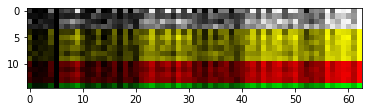

In [35]:
rM=resM.copy()
rM=rM.transpose()
print(rM.shape)
master=numpy.zeros((rM.shape[0],rM.shape[1],3))
for i in range(15):
    m=rM[i][62]
    print(m,ceil(m))
    #rM[i]=rM[i]/ceil(rM[i].max())
    for j in range(63):
        if i in [0,1,2,3]:
            master[i][j]=numpy.array([rM[i][j]/m,rM[i][j]/m,rM[i][j]/m])
        if i in [4,5,6,7,8,9]:
            master[i][j]=numpy.array([rM[i][j]/m,rM[i][j]/m,0.0])
        if i in [10,11,12,13]:
            master[i][j]=numpy.array([rM[i][j]/m,0.0,0.0])
        if i in [14]:
            master[i][j]=numpy.array([0.0,rM[i][j]/m,0.0])
imshow(master)#,cmap='gray')
#resM=numpy.zeros((rM.transpose().shape[0],rM.transpose().shape[1],4))
#for i in range(resM.shape[0]):
#    for j in range(resM.shape[1]):


4.871457991105636e-06 0.48866574185735895


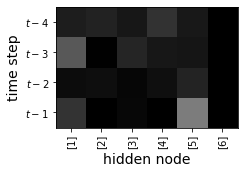

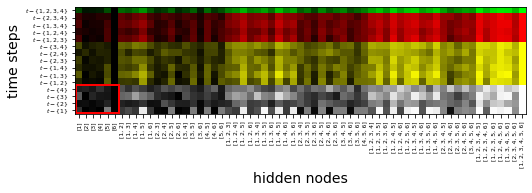

In [36]:
figure(figsize=[3.5,3])
#gs=GridSpec(1, 2, width_ratios=[1, 2])

yL=[]
yLpure=[]
for w in powerset([1,2,3,4])[1:]:
    yL.append(r"$t-\{"+str(list(w))[1:-1]+"\}$")
    yLpure.append(r"$t-"+str(list(w))[1:-1]+"$")
xL=[]
for h in powerset([1,2,3,4,5,6])[1:]:
    xL.append(str(list(h)))
#subplot(gs[0])
minM=master[:4,:6]
imshow(minM)#,cmap="gray")
print(minM.min(),minM.max())
xticks(range(6),xL[:6],rotation=90)
yticks(range(4),yLpure[:4])
ylim(-0.5,3.5)
xlim(-0.5,5.5)
xlabel("hidden node",fontsize=14)
ylabel("time step",fontsize=14)
tight_layout()
savefig("{0}_singleMapping.pdf".format(modelName))

#subplot(gs[1])
figure(figsize=[7.5,3])
imshow(master)#,cmap="gray")
xticks(range(len(xL)),xL,rotation=90,fontsize=6)
yticks(range(len(yL)),yL,fontsize=6)
ylim(-0.5,14.5)
xlim(-0.5,62.5)
ylabel("time steps",fontsize=14)
xlabel("hidden nodes",fontsize=14)
gca().add_patch(Rectangle((-0.4,-0.4),6,4,color='r',fill=False,linewidth=2))
tight_layout()
savefig("{0}_allMappings.pdf".format(modelName))


##### following code takes very long to run!

In [ ]:
modelName="LSTM"
# n=5
np=10000
model=LSTMModel(5,1)

model.load_state_dict(torch.load("{0}_example_{1}back_{2}nodes.model".format(modelName,5,5)))
model.eval()

base=list(1.0*(numpy.random.random((np))>0.5))
signals=numpy.array(base).reshape((1,np,1))
target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
signals=torch.tensor(signals)
target=torch.tensor(target)
optimizer.zero_grad()
model.resetToZero(1)
history = numpy.array(model.retreiveAllHistory(signals.float()))


#print(outputs.shape,history.shape)
M=numpy.zeros((15,10000))
for i in [4,5,6,7,8,9,10,11,12,13]:
    M[i]=medianBinarizationVector(history.reshape((np,10)).transpose()[i-4])
W=list(signals.reshape((np)).detach().numpy())
for i in range(4):
    if i==0:
        M[i]=W
    else:
        M[i]=[0]*i+W[:-i]
M[10]=W
    
M=M.transpose()
hiddenPS=powerset([4,5,6,7,8,9,10,11,12,13])[1:]
worldPS=powerset([0,1,2,3])[1:]
resM=numpy.zeros((1023,15))

S=extractBitPattern(M,[14])
for w in worldPS:
    for h in hiddenPS:
        W=extractBitPattern(M,list(w))
        H=extractBitPattern(M,list(h))
        resM[hiddenPS.index(h)][worldPS.index(w)]=computeR(W,H,S)


In [ ]:
BU=resM.copy()

In [ ]:
figure(figsize=[7.5,6])
yL=[]
for w in powerset([1,2,3,4])[1:]:
    yL.append(r"$t-\{"+str(list(w))[1:-1]+"\}$")
xL=[]
xLpure=[]
for h in powerset([1,2,3,4,5,6,7,8,9,10])[1:]:
    xL.append(str(list(h)))
    xLpure.append(r"$t-"+str(list(w))[1:-1]+"$")

print(resM.max(),resM.min())
for i in range(8):
    subplot(8,1,i+1)
    imshow(normResM[:15,(i*128):((i+1)*128)],interpolation='nearest')
    #imshow(resM.transpose()[:15,(i*128):((i+1)*128)],vmin=0.0,vmax=1.0,cmap='gray')
   
    ylim(-0.5,15.0)
    if i==7:
        xticks([0,20,40,60,80,100,120],["","","","","","",""],fontsize=12)
        xlabel("[1] -> all hidden state subsets -> [1-10]",fontsize=12)
    else:
        xticks([0,20,40,60,80,100,120],["","","","","","",""],fontsize=12)
    yticks([0,2,4,6,8,10,12,14],[yL[0],"","",yL[4],"",yL[10],"","",],fontsize=9)
tight_layout()
savefig("LSTM_allMappings.pdf")

In [ ]:
print(resM.shape)
normResM=numpy.zeros((15,1023,3))
for i in range(len(hiddenPS)):
    ls=resM[i].max()
    #print(i,len(hiddenPS[i]),ls)
    ls=1.0
    for j in range(len(worldPS)):
        ls=resM[1022][j]
        if len(worldPS[j])==1:
            normResM[j][i]=numpy.array([resM[i][j]/ls,resM[i][j]/ls,resM[i][j]/ls])
        if len(worldPS[j])==2:
            normResM[j][i]=numpy.array([resM[i][j]/ls,resM[i][j]/ls,0.0])
        if len(worldPS[j])==3:
            normResM[j][i]=numpy.array([resM[i][j]/ls,0.0,0.0])
        if len(worldPS[j])==4:
            normResM[j][i]=numpy.array([0.0,resM[i][j]/ls,0.0])
for i in range(8):
    subplot(8,1,i+1)
    imshow(normResM[:15,(i*128):((i+1)*128)])

In [ ]:
figure(figsize=[7.5,3])
imshow(normResM[:4,:10],cmap="gray")
ylim(-0.5,3.5)
xlim(-0.5,9.5)
yticks(range(4),yLpure,fontsize=12)
xticks([0,1,2,3,4,5,6,7,8,9],["H1","H2","H3","H4","H5","C1","C2","C3","C4","C5"],fontsize=12)
xlabel("hidden states | cell states",fontsize=14)
ylabel("time points",fontsize=14)
plot([4.5,4.5],[-0.5,3.5],'r',linewidth=4.0)
tight_layout()
savefig("LSTM_singleMappings.pdf")

### no need to rerun the following code - data exists 

In [ ]:
for rep in range(20):
    #model=LSTMModel(5,1)
    hiddenSize=10
    model=RNNModel(hiddenSize,1)
    optimizer = optim.Adam(model.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
    error = nn.MSELoss()

    episodes=2000

    nBack=5
    L=[]
    C=[]
    tic()
    for episode in range(episodes):
        base=list(1.0*(numpy.random.random((256))>0.5))
        signals=numpy.array(base).reshape((1,256,1))
        target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
        signals=torch.tensor(signals)
        target=torch.tensor(target)
        optimizer.zero_grad()
        model.resetToZero(1)
        outputs,history = model(signals.float())
        loss = error(outputs, target.float())
        L.append(float(loss))
        loss.backward()
        optimizer.step()
        if episode%1999 ==0:
            print(episode,L[-1])
        o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
        t=target.detach().numpy().reshape((256))
        c=abs(o-t).sum()/256
        C.append(c)
    plot(L,'k')
    plot(C)
    print(toc())

    torch.save(model.state_dict(), "RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,hiddenSize,rep))
#myRNN=RNNModel(6,1,startZero=False)

In [ ]:
pG=pickle.load( open( "saveGRUoptimizationData.p", "rb" ) )

### no need to rerun the following code - data exists 

In [ ]:
nBack=5
nns=["RNN","LSTM","GRU"]
np=10000
#allCollector=dict()
for name in nns:
    for reps in range(2):
        if name=="RNN":
            model=RNNModel(6,1)
            model.load_state_dict(torch.load("RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
        if name=="LSTM":
            model=LSTMModel(5,1)
            model.load_state_dict(torch.load("LSTM_{0}back_{1}nodes_{2}rep.model".format(nBack,5,reps)))
            M=numpy.zeros((15,np))
            hiddenNodeSet=[4,5,6,7,8,9,10,11,12,13]
        if name=="GRU":
            model=GRUModel(6,1)
            model.load_state_dict(torch.load("GRU_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
        model.eval()
        
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
            
        signals=torch.tensor(signals)
        history = numpy.array(model.retreiveAllHistory(signals.float()))
        
        
        
        for i in hiddenNodeSet:
            M[i]=medianBinarizationVector(history.transpose()[i-4])
        W=list(signals.reshape((np)).detach().numpy())
        for i in range(4):
            if i==0:
                M[i]=W
            else:
                M[i]=[0]*i+W[:-i]
        M[-1]=W
        M=M.transpose()
        hiddenPS=powerset(hiddenNodeSet)[1:]
        worldPS=powerset([0,1,2,3])[1:]
        collector=[dict(),dict(),dict(),dict(),dict()]
        S=extractBitPattern(M,[M.shape[1]-1])
        for w in [1,2,3,4]:
            W=extractBitPattern(M,[w])
            for h in hiddenPS:
                H=extractBitPattern(M,list(h))
                res=computeR(W,H,S)
                l=len(list(h))
                if l not in collector[w]:
                    collector[w][l]=[]
                collector[w][l].append(res)
        allCollector["{0} {1}".format(name,reps)]=collector
        print(name,reps)

In [39]:
allCollector = pickle.load( open( "allCollectorMatrices.p", "rb" ) )

In [42]:
N=50
for n in range(N):
    data=read_csv("dataMarkovnBack/GEN_{0}__9.csv".format(n))
    collector=[dict(),dict(),dict(),dict(),dict()]
    for j in range(63):
        subset=eval(data["powerset"][j])
        for i in [1,2,3,4]:
            if len(subset) not in collector[i]:
                collector[i][len(subset)]=[]
            collector[i][len(subset)].append(data[str(i)][j])
    allCollector["Markov {0}".format(n)]=collector

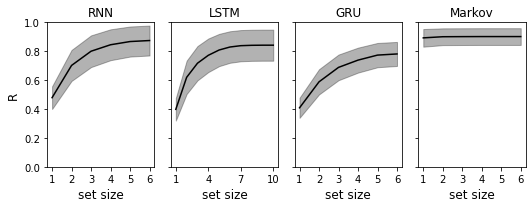

In [43]:
nns=["RNN","LSTM","GRU","Markov"]
np=10000
where=1
figure(figsize=[7.5,3])
for name in nns:
    M=[]
    for reps in range(20):
        c=allCollector["{0} {1}".format(name,reps)]
        for i in [1,2,3,4]:
            x=[]
            y=[]
            m=0.0
            for e in sort(list(c[i].keys())):
                x.append(e)
                n=max(c[i][e])
                if m>n:
                    n=m
                else:
                    m=n
                y.append(n)
            M.append(y)
    M=numpy.array(M)
    subplot(1,4,where)
    where+=1
    d=M.std(0)/sqrt(20)
    m=M.mean(0)
    fill_between(range(len(d)),m+d,m-d,alpha=0.3,color='k')
    plot(m,'k')
    ylim(0,1)
    if len(d)==6:
        xticks([0,1,2,3,4,5],["1","2","3","4","5","6"])
        xlabel("set size",fontsize=12)
    else:
        xticks([0,3,6,9],["1","4","7","10"])
    xlabel("set size",fontsize=12)
    title(name,fontsize=12)
    if name=="RNN":
        ylabel("R",fontsize=12)
    else:
        yticks([0.0,0.2,0.4,0.6,0.8,1.0],["","","","","",""])
#subplot(1,4,where)
#plot([0,1],[0,1],'k')
#text(0.1,0.8,"markov\n Brain\nmissing")
tight_layout()
savefig("fragmentationAllFour.pdf")

In [44]:
data=read_csv("dataMarkovnBack/GEN_{0}__9.csv".format(1))

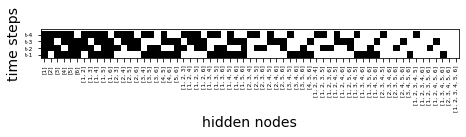

In [45]:
figure(figsize=[7.5,3])
PS=powerset([5,6,7,8,9,10])[1:]
PST=powerset([1,2,3,4,5,6])[1:]
PSS=[]
for ps in PST:
    PSS.append(str(list(ps)))
M=numpy.zeros((4,len(PS)))
for t in range(4):
    for i in range(63):
        M[t][PS.index(tuple(eval(data["powerset"][i])))]=data[str(t+1)][i]
imshow(M,cmap='gray')
xticks(range(len(PSS)),PSS,fontsize=6,rotation=90)
yticks([0,1,2,3],["t-1","t-2","t-3","t-4"],fontsize=6)
ylim(-0.5,3.8)
ylabel("time steps",fontsize=14)
xlabel("hidden nodes",fontsize=14)
savefig("MB_allMappings.pdf")

In [ ]:
nBack=5
nns=["RNN","GRU","LSTM"]
np=10000
#allCollector=dict()
for name in nns:
    for reps in range(20):
        if name=="RNN":
            model=RNNModel(6,1)
            model.load_state_dict(torch.load("RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
            hiddenNoiseSet=[0,1,2,3,4,5]
        if name=="LSTM":
            model=LSTMModel(5,1)
            model.load_state_dict(torch.load("LSTM_{0}back_{1}nodes_{2}rep.model".format(nBack,5,reps)))
            M=numpy.zeros((15,np))
            hiddenNodeSet=[4,5,6,7,8,9,10,11,12,13]
            hiddenNoiseSet=[0,1,2,3,4,5,6,7,8,9]
        if name=="GRU":
            model=GRUModel(6,1)
            model.load_state_dict(torch.load("GRU_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
            hiddenNoiseSet=[0,1,2,3,4,5]
        model.eval()
        
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
            
        signals=torch.tensor(signals)
        history = numpy.array(model.retreiveAllHistory(signals.float()))
        
        
        
        for i in hiddenNodeSet:
            M[i]=medianBinarizationVector(history.transpose()[i-4])
        W=list(signals.reshape((np)).detach().numpy())
        for i in range(4):
            if i==0:
                M[i]=W
            else:
                M[i]=[0]*i+W[:-i]
        M[-1]=W
        M=M.transpose()
        hiddenPS=powerset(hiddenNodeSet)[1:]
        worldPS=powerset([0,1,2,3])[1:]
        collector=dict()
        S=extractBitPattern(M,[M.shape[1]-1])
        for w in [1,2,3,4]:
            W=extractBitPattern(M,[w-1])
            for h in hiddenPS:
                H=extractBitPattern(M,list(h))
                res=computeR(W,H,S)
                collector["{0} {1}".format(w,h)]=res
                if res>1.0:
                    print(name,reps,w,h,res)
        #fullR=[]
        #W=extractBitPattern(M,[0,1,2,3])
        #for h in hiddenPS:
        #    H=extractBitPattern(M,list(h))
        #    res=computeR(W,H,S)
        #    fullR.append(res)
            
        #allCollector["{0} {1}".format(name,reps)]=collector
        PSnoise=powerset(hiddenNoiseSet)[1:]
        PSnode=powerset(hiddenNodeSet)[1:]
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
        signals=torch.tensor(signals)
        target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
        W=dict()
        for p in PSnoise:
            actions=numpy.array(model.retreiveAllActionsWithNoise(signals.float(),p,0.2))
            o=1.0*(actions.reshape((np))>0.5)
            t=target.reshape((np))
            c=abs(o-t).sum()/np
            #print(p,c)
            W[p]=c
        if False:
            X=[]
            Y=[]
            for i in range(len(PSnoise)):
                w=W[PSnoise[i]]
                a=[]
                for j in [1,2,3,4]:
                    a.append(collector["{0} {1}".format(j,PSnode[i])])
                X.append(w)
                Y.append(mean(a)/float(len(PSnode[i])))
            figure()
            plot(X,Y,'k.')
        if True:
            D=DataFrame()
            col=[]
            nameA=[]
            nameB=[]
            for i in range(len(PSnoise)):
                col.append(W[PSnoise[i]])
                nameA.append(PSnoise[i])
                nameB.append(PSnode[i])
            D["noiseSet"]=nameA
            D["nodeSet"]=nameB
            D["W"]=col
            #D["R"]=fullR
            for j in [1,2,3,4]:
                col=[]
                for i in range(len(PSnoise)):
                    col.append(collector["{0} {1}".format(j,PSnode[i])])
                D["t{0}".format(j)]=col
            D.to_csv("WRdata_{0}_{1}.csv".format(name,reps))
        #for i in hiddenNodeSet
        print(name,reps)

### no need to rerun the following code - data exists

In [ ]:
nBack=5
nns=["RNN","GRU","LSTM"]
np=10000
#allCollector=dict()
for name in nns:
    for reps in range(20):
        if name=="RNN":
            model=RNNModel(6,1)
            model.load_state_dict(torch.load("RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[5,6,7,8,9,10]
            hiddenNoiseSet=[0,1,2,3,4,5]
        if name=="LSTM":
            model=LSTMModel(5,1)
            model.load_state_dict(torch.load("LSTM_{0}back_{1}nodes_{2}rep.model".format(nBack,5,reps)))
            M=numpy.zeros((15,np))
            hiddenNodeSet=[5,6,7,8,9,10,11,12,13,14]
            hiddenNoiseSet=[0,1,2,3,4,5,6,7,8,9]
        if name=="GRU":
            model=GRUModel(6,1)
            model.load_state_dict(torch.load("GRU_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[5,6,7,8,9,10]
            hiddenNoiseSet=[0,1,2,3,4,5]
        model.eval()
        
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
            
        signals=torch.tensor(signals)
        history = numpy.array(model.retreiveAllHistory(signals.float()))
        
        
        
        for i in hiddenNodeSet:
            M[i]=medianBinarizationVector(history.transpose()[i-5])
        W=list(signals.reshape((np)).detach().numpy())
        for i in range(5):
            if i==0:
                M[i]=W
            else:
                M[i]=[0]*i+W[:-i]
        M[-1]=W
        M=M.transpose()
        hiddenPS=powerset(hiddenNodeSet)[1:]
        worldPS=powerset([0,1,2,3])[1:]
        collector=dict()
        S=extractBitPattern(M,[M.shape[1]-1])
        for w in [1,2,3,4]:
            W=extractBitPattern(M,[w])
            for h in hiddenPS:
                H=extractBitPattern(M,list(h))
                res=computeR(W,H,S)
                collector["{0} {1}".format(w,h)]=res
                if res>1.0:
                    print(name,reps,w,h,res)
        #fullR=[]
        #W=extractBitPattern(M,[0,1,2,3])
        #for h in hiddenPS:
        #    H=extractBitPattern(M,list(h))
        #    res=computeR(W,H,S)
        #    fullR.append(res)
            
        #allCollector["{0} {1}".format(name,reps)]=collector
        PSnoise=powerset(hiddenNoiseSet)[1:]
        PSnode=powerset(hiddenNodeSet)[1:]
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
        signals=torch.tensor(signals)
        target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
        W=dict()
        for p in PSnoise:
            actions=numpy.array(model.retreiveAllActionsWithNoise(signals.float(),p,0.2))
            o=1.0*(actions.reshape((np))>0.5)
            t=target.reshape((np))
            c=abs(o-t).sum()/np
            #print(p,c)
            W[p]=c
        if False:
            X=[]
            Y=[]
            for i in range(len(PSnoise)):
                w=W[PSnoise[i]]
                a=[]
                for j in [1,2,3,4]:
                    a.append(collector["{0} {1}".format(j,PSnode[i])])
                X.append(w)
                Y.append(mean(a)/float(len(PSnode[i])))
            figure()
            plot(X,Y,'k.')
        if True:
            D=DataFrame()
            col=[]
            nameA=[]
            nameB=[]
            for i in range(len(PSnoise)):
                col.append(W[PSnoise[i]])
                nameA.append(PSnoise[i])
                nameB.append(PSnode[i])
            D["noiseSet"]=nameA
            D["nodeSet"]=nameB
            D["W"]=col
            #D["R"]=fullR
            for j in [1,2,3,4]:
                col=[]
                for i in range(len(PSnoise)):
                    col.append(collector["{0} {1}".format(j,PSnode[i])])
                D["t{0}".format(j)]=col
            D.to_csv("WRdata_HIGHRES_{0}_{1}.csv".format(name,reps))
        #for i in hiddenNodeSet
        print(name,reps)

### no need to rerun the following code - data exists

In [ ]:

nBack=5
nns=["RNN","GRU","LSTM"]
np=10000
#allCollector=dict()
for name in nns:
    for reps in range(10):
        if name=="RNN":
            model=RNNModel(10,1)
            model.load_state_dict(torch.load("RNN_sizeCheck_{0}_{1}.model".format(10,reps)))
            M=numpy.zeros((15,np))
            hiddenNodeSet=[5,6,7,8,9,10,11,12,13,14]
            hiddenNoiseSet=[0,1,2,3,4,5,6,7,8,9]
        model.eval()
        
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
            
        signals=torch.tensor(signals)
        history = numpy.array(model.retreiveAllHistory(signals.float()))
        
        
        
        for i in hiddenNodeSet:
            M[i]=medianBinarizationVector(history.transpose()[i-5])
        W=list(signals.reshape((np)).detach().numpy())
        for i in range(5):
            if i==0:
                M[i]=W
            else:
                M[i]=[0]*i+W[:-i]
        M[-1]=W
        M=M.transpose()
        hiddenPS=powerset(hiddenNodeSet)[1:]
        worldPS=powerset([0,1,2,3])[1:]
        collector=dict()
        S=extractBitPattern(M,[M.shape[1]-1])
        for w in [1,2,3,4]:
            W=extractBitPattern(M,[w])
            for h in hiddenPS:
                H=extractBitPattern(M,list(h))
                res=computeR(W,H,S)
                collector["{0} {1}".format(w,h)]=res
                if res>1.0:
                    print(name,reps,w,h,res)
        #fullR=[]
        #W=extractBitPattern(M,[0,1,2,3])
        #for h in hiddenPS:
        #    H=extractBitPattern(M,list(h))
        #    res=computeR(W,H,S)
        #    fullR.append(res)
            
        #allCollector["{0} {1}".format(name,reps)]=collector
        PSnoise=powerset(hiddenNoiseSet)[1:]
        PSnode=powerset(hiddenNodeSet)[1:]
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
        signals=torch.tensor(signals)
        target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    
        W=dict()
        for p in PSnoise:
            actions=numpy.array(model.retreiveAllActionsWithNoise(signals.float(),p,0.2))
            o=1.0*(actions.reshape((np))>0.5)
            t=target.reshape((np))
            c=abs(o-t).sum()/np
            #print(p,c)
            W[p]=c
        if False:
            X=[]
            Y=[]
            for i in range(len(PSnoise)):
                w=W[PSnoise[i]]
                a=[]
                for j in [1,2,3,4]:
                    a.append(collector["{0} {1}".format(j,PSnode[i])])
                X.append(w)
                Y.append(mean(a)/float(len(PSnode[i])))
            figure()
            plot(X,Y,'k.')
        if True:
            D=DataFrame()
            col=[]
            nameA=[]
            nameB=[]
            for i in range(len(PSnoise)):
                col.append(W[PSnoise[i]])
                nameA.append(PSnoise[i])
                nameB.append(PSnode[i])
            D["noiseSet"]=nameA
            D["nodeSet"]=nameB
            D["W"]=col
            #D["R"]=fullR
            for j in [1,2,3,4]:
                col=[]
                for i in range(len(PSnoise)):
                    col.append(collector["{0} {1}".format(j,PSnode[i])])
                D["t{0}".format(j)]=col
            D.to_csv("WRdata_LARGE_{0}_{1}.csv".format(name,reps))
        #for i in hiddenNodeSet
        print(name,reps)

#### SAME AS ABOVE BUT for only R not single temporal R - no need to rerun

In [ ]:
nBack=5
nns=["LSTM"]#"RNN","GRU","LSTM"]
np=10000
#allCollector=dict()
for name in nns:
    for reps in range(20):
        if name=="RNN":
            model=RNNModel(6,1)
            model.load_state_dict(torch.load("RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
            hiddenNoiseSet=[0,1,2,3,4,5]
        if name=="LSTM":
            model=LSTMModel(5,1)
            model.load_state_dict(torch.load("LSTM_{0}back_{1}nodes_{2}rep.model".format(nBack,5,reps)))
            M=numpy.zeros((15,np))
            hiddenNodeSet=[4,5,6,7,8,9,10,11,12,13]
            hiddenNoiseSet=[0,1,2,3,4,5,6,7,8,9]
        if name=="GRU":
            model=GRUModel(6,1)
            model.load_state_dict(torch.load("GRU_{0}back_{1}nodes_{2}rep.model".format(nBack,6,reps)))
            M=numpy.zeros((11,np))
            hiddenNodeSet=[4,5,6,7,8,9]
            hiddenNoiseSet=[0,1,2,3,4,5]
        model.eval()
        
        base=list(1.0*(numpy.random.random((np))>0.5))
        signals=numpy.array(base).reshape((1,np,1))
            
        signals=torch.tensor(signals)
        history = numpy.array(model.retreiveAllHistory(signals.float()))
        
        
        PSnoise=powerset(hiddenNoiseSet)[1:]
        PSnode=powerset(hiddenNodeSet)[1:]

        for i in hiddenNodeSet:
            M[i]=medianBinarizationVector(history.transpose()[i-4])
        W=list(signals.reshape((np)).detach().numpy())
        for i in range(4):
            if i==0:
                M[i]=W
            else:
                M[i]=[0]*i+W[:-i]
        M[-1]=W
        M=M.transpose()
        hiddenPS=powerset(hiddenNodeSet)[1:]
        worldPS=powerset([0,1,2,3])[1:]
        collector=dict()
        S=extractBitPattern(M,[M.shape[1]-1])
        fullR=[]
        W=extractBitPattern(M,[0,1,2,3])
        for h in hiddenPS:
            H=extractBitPattern(M,list(h))
            res=computeR(W,H,S)
            fullR.append(res)
            
        
        if True:
            D=DataFrame()
            col=[]
            nameA=[]
            nameB=[]
            for i in range(len(PSnoise)):
                nameA.append(PSnoise[i])
                nameB.append(PSnode[i])
            print(len(nameA),len(nameB),len(fullR))
            D["noiseSet"]=nameA
            D["nodeSet"]=nameB
            D["R"]=fullR
            D.to_csv("WRdata_RONLY_{0}_{1}.csv".format(name,reps))
        #for i in hiddenNodeSet
        print(name,reps)

In [ ]:
D=DataFrame()
col=[]
nameA=[]
nameB=[]
for i in range(len(PSnoise)):
    col.append(W[PSnoise[i]])
    nameA.append(PSnoise[i])
    nameB.append(PSnode[i])
D["noiseSet"]=nameA
D["nodeSet"]=nameB
D["W"]=col
for j in [1,2,3,4]:
    col=[]
    for i in range(len(PSnoise)):
        col.append(collector["{0} {1}".format(j,PSnode[i])])
    D["t{0}".format(j)]=col
D.to_csv("test.csv")

In [ ]:
#model=RNNModel(6,1)
#model.load_state_dict(torch.load("RNN_{0}back_{1}nodes_{2}rep.model".format(nBack,6,0)))
#model=GRUModel(6,1)
#model.load_state_dict(torch.load("GRU_{0}back_{1}nodes_{2}rep.model".format(nBack,6,0)))
model=LSTMModel(5,1)
model.load_state_dict(torch.load("LSTM_{0}back_{1}nodes_{2}rep.model".format(nBack,5,0)))
hiddenNodeSet=[4,5,6,7,8,9,10,11,12,13]
hiddenNoiseSet=[0,1,2,3,4,5,6,7,8,9]

base=list(1.0*(numpy.random.random((np))>0.5))
signals=numpy.array(base).reshape((1,np,1))
signals=torch.tensor(signals)
target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((np,1))    

PSnoise=powerset(hiddenNoiseSet)[1:]
PSnode=powerset(hiddenNodeSet)[1:]
W=dict()
for p in PSnoise:
    actions=numpy.array(model.retreiveAllActionsWithNoise(signals.float(),p,0.2))
    o=1.0*(actions.reshape((np))>0.5)
    t=target.reshape((np))
    c=abs(o-t).sum()/np
    print(p,c)
    W[p]=c

In [ ]:
O,H=model(signals.float())

In [ ]:
#model=RNNModel(6,1)
#model.load_state_dict(torch.load("RNN_example_{0}back_{1}nodes.model".format(nBack,6)))

base=list(1.0*(numpy.random.random((256))>0.5))
signals=numpy.array(base).reshape((1,256,1))
target=numpy.array([0.0]*nBack+base[:-nBack]).reshape((256,1))    
signals=torch.tensor(signals)
target=torch.tensor(target)
model.resetToZero(1)
outputs,history = model(signals.float())
o=1.0*(outputs.detach().numpy().reshape((256))>0.5)
t=target.detach().numpy().reshape((256))
c=abs(o-t).sum()/256
print(c)

In [ ]:
PSnoise=powerset(hiddenNoiseSet)[1:]
PSnode=powerset(hiddenNodeSet)[1:]
X=[]
Y=[]
for i in range(len(PSnoise)):
    w=W[PSnoise[i]]
    a=[]
    for j in [1,2,3,4]:
        a.append(collector["{0} {1}".format(j,PSnode[i])])
    #print(w,a)
    X.append(w)
    Y.append(mean(a)/float(len(PSnode[i])))
plot(X,Y,'k.')

### no need to rerun the following code - data exists

In [ ]:
#the cell that translates the MArkov brain noise and r stuff into the same format as the other csvs
N=50
for n in range(N):
    dataW=read_csv("dataMarkovnBack/NOISE_{0}.csv".format(n))
    dataR=read_csv("dataMarkovnBack/GEN_{0}__9.csv".format(n))
    D=DataFrame()
    PS=[]
    for p in dataR["powerset"]:
        PS.append(tuple(eval(p)))
    D["noiseSet"]=PS
    D["nodeSet"]=PS
    D["W"]=dataW["W"]
    for i in [1,2,3,4]:
        D["t{0}".format(i)]=dataR[str(i)]
    D.to_csv("WRdata_MARKOV_{0}.csv".format(n))

RNN slope 2.2902245931195417 int -0.14728858526759508 r 0.6068844131450614 p 0.0 stde 0.02965713415358716


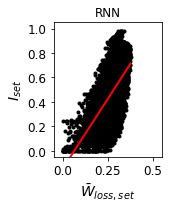

In [50]:
from scipy import stats
nBack=5
nns=["RNN"]#,"GRU","LSTM","MARKOV"]
N=10
figure(figsize=[7.5,3])
collectorMRA=dict()
for name in nns:
    X=[]
    Y=[]
    Z=[]
    for n in range(N):
        if name == "MARKOV":
            data=read_csv("WRdata_{0}_{1}.csv".format(name,n))
        else:
            #data=read_csv("WRdata_HIGHRES_{0}_{1}.csv".format(name,n))
            data=read_csv("WRdata_LARGE_{0}_{1}.csv".format(name,n))
        for i in range(len(data["W"])):
            setSize=len(eval(data["nodeSet"][i]))
            Z.append(setSize)
            X.append(data["W"][i])
            A=[data["t1"][i],data["t2"][i],data["t3"][i],data["t4"][i]]
            Y.append(mean(A))
    collectorMRA[name]=[X,Y,Z]
    where=nns.index(name)+1
    subplot(1,4,where)
    plot(X,Y,'.k')
    title(name)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    print(name,"slope",slope,"int",intercept,"r", r_value,"p", p_value,"stde", std_err)
    x=linspace(0.0,max(X),101)
    plot(x, intercept + slope*x, 'r',linewidth=2.0)
    #data = pandas.DataFrame({'W': X, 'I': Y, 'S': Z})

    #model = ols("W ~ I + S", data).fit()
    #print("name:",name)
    #print(model.summary())
    #print("\nRetrieving manually the parameter estimates:")
    #params=model._results.params
    #print(name,params)
    #anova_results = anova_lm(model)
    #print(anova_results)
    
    #x=linspace(0.0,max(X),101)
    #plot(x, params[0] + params[1]*x, 'r',linewidth=2.0)
    #plot(x, params[0] + params[2]*linspace(0.0,max(Z),101), 'b',linewidth=2.0)
    ylim(-0.05,1.05)
    xlim(-0.05,0.55)
    if where==1:
        yticks(fontsize=12)
        ylabel(r"$I_{set}$",fontsize=14)
    else:
        yticks([0,0.2,0.4,0.6,0.8,1.0],["","","","","",""],fontsize=12)
    xticks([0,0.25,0.5],["0.0","0.25","0.5"],fontsize=12)
    xlabel(r"$\bar{W}_{loss,set}$",fontsize=14)
    
    data = pandas.DataFrame({'W': X, 'I': Y, 'S': Z})

    model = ols("W ~ I + S", data).fit()
    #print(model._results.params)
    
tight_layout()
#savefig("perfLossPerSet.pdf")

RNN [0.13833696 0.01137296 0.02599649]
               df     sum_sq    mean_sq             F  PR(>F)
I             1.0  10.950001  10.950001  10084.531799     0.0
S             1.0   7.675802   7.675802   7069.119398     0.0
Residual  10227.0  11.104696   0.001086           NaN     NaN


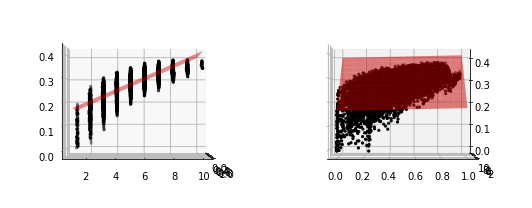

In [51]:
fig = plt.figure(figsize=[7.5,3])
where=1
for name in ["RNN"]:
    X,Y,Z=collectorMRA[name]
    W = numpy.array(X).flatten()
    I = numpy.array(Y).flatten()
    S = numpy.array(Z).flatten()
    R = numpy.random.random(S.shape)

    data = pandas.DataFrame({'W': W, 'I': I, 'S': S, 'R':R})

    model = ols("W ~ I + S", data).fit()
    #print("name:",name)
    #print(model.summary())
    #print("\nRetrieving manually the parameter estimates:")
    params=model._results.params
    anova_results = anova_lm(model)
    print(name,params)
    print(anova_results)

    #print('\nANOVA results')
    #print(anova_results)
    
    #x = np.linspace(0, 1, 21)
    # We generate a 2D grid
    #X, Y = np.meshgrid(x, x)

    #Z=0.16639304-0.07557765*Y+0.05676302*Z
    for u in range(2):
        ax = fig.add_subplot(1,2,u+1,projection='3d',elev=0.0, azim=-90.0*u)
        #ax.plot_surface(X,Y,Z)
        ax.scatter(I,S,W,marker='.',color='k')
        i,s=numpy.meshgrid(linspace(0,1,11),linspace(min(S),max(S),11))
        w=params[0]+params[1]*i+params[2]*s
        ax.plot_surface(i,s,w,color='r',alpha=0.5)
       
    where+=1
fig.tight_layout()

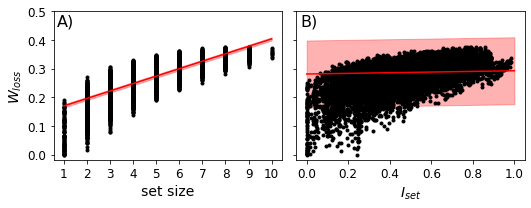

In [52]:
figure(figsize=[7.5,3])
subplot(1,2,1)
plot(S,W,'.k')
x=linspace(1,10,101)
fill_between(x,params[0]+params[1]*min(I)+params[2]*x,params[0]+params[1]*max(I)+params[2]*x,color="r",alpha=0.3)
plot(x,params[0]+params[1]*0.5*(min(I)+max(I))+params[2]*x,color="r")
xlabel("set size",fontsize=14)
ylabel(r"$W_{loss}$",fontsize=14)
xticks([1,2,3,4,5,6,7,8,9,10],fontsize=12)
yticks([0.0,0.1,0.2,0.3,0.4,0.5],fontsize=12)
text(0.7,0.45,"A)",fontsize=16)

subplot(1,2,2)
plot(I,W,'.k')
x=linspace(0,1.0,101)
fill_between(x,params[0]+params[1]*x+params[2]*min(S),params[0]+params[1]*x+params[2]*max(S),color="r",alpha=0.3)
plot(x,params[0]+params[1]*x+params[2]*0.5*(min(S)+max(S)),color="r")

ylabel("")
xlabel(r"$I_{set}$",fontsize=14)
yticks([0.0,0.1,0.2,0.3,0.4,0.5],[])
xticks(fontsize=12)
text(-0.03,0.45,"B)",fontsize=16)
tight_layout()
savefig("multipleRegression.pdf")

RNN 20 480 0.041666666666666664
GRU 15 480 0.03125
LSTM 107 800 0.13375
MARKOV 2 480 0.004166666666666667


<Figure size 540x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

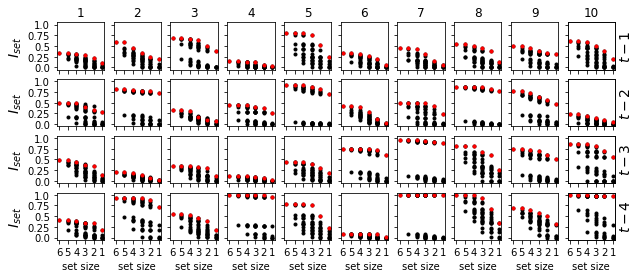

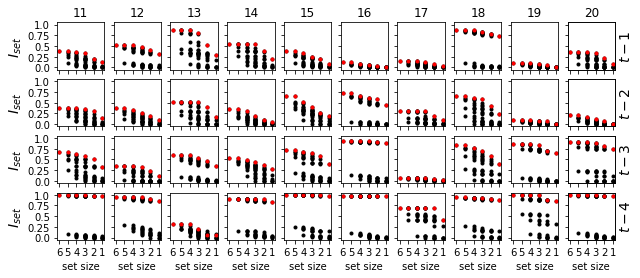

<Figure size 432x288 with 0 Axes>

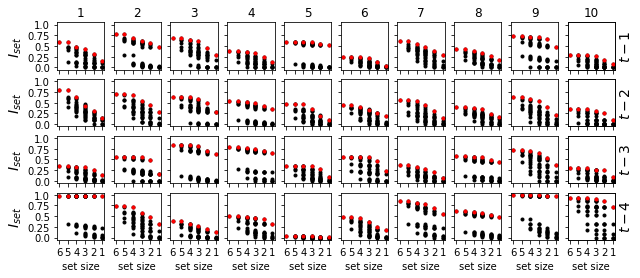

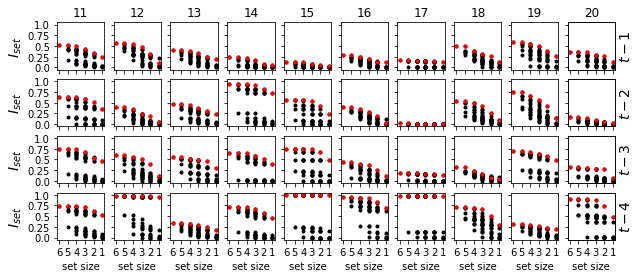

<Figure size 432x288 with 0 Axes>

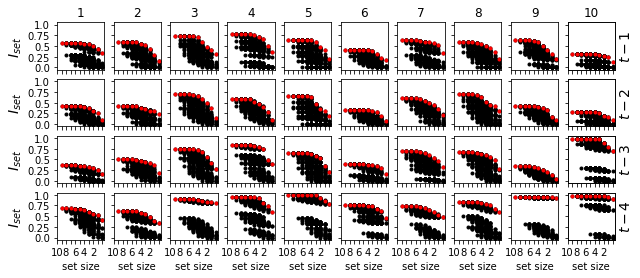

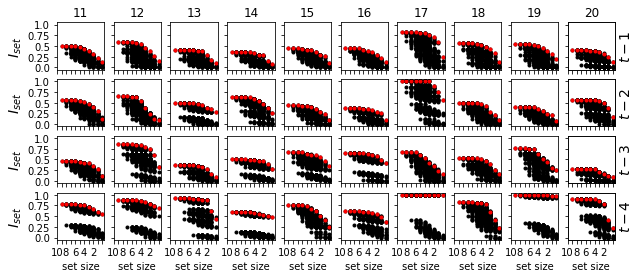

<Figure size 432x288 with 0 Axes>

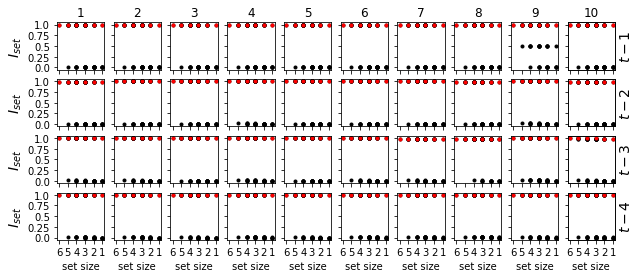

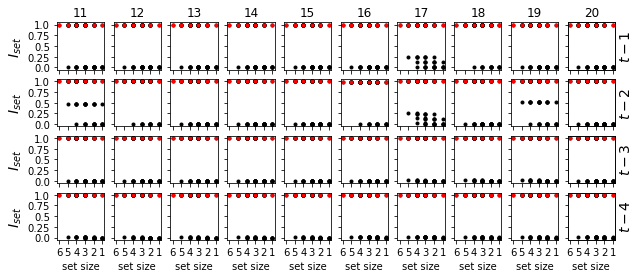

In [48]:
perfectMarkov=[0,1,2,3,9,10,11,12,13,14,17,18,19,27,28,29,32,33,34,35]
from scipy import stats
nBack=5
nns=["RNN","GRU","LSTM","MARKOV"]
N=20
figure(figsize=[7.5,6])
sequenceCollector=dict()
leftoverCollector=dict()
Wcollector=dict()
for name in nns:
    X=[]
    Y=[]
    Z=[]
    figure()
    Wall=[]
    MWall=[]
    figure(figsize=[10,4])
    outlier=0
    total=0
    for n in range(N):
        if name == "MARKOV":
            data=read_csv("WRdata_{0}_{1}.csv".format(name,perfectMarkov[n]))
        else:
            data=read_csv("WRdata_HIGHRES_{0}_{1}.csv".format(name,n))
            #data=read_csv("WRdata_LARGE_{0}_{1}.csv".format(name,n))
        nodeSet=list()
        for i in data["nodeSet"]:
            nodeSet.append(list(eval(i)))
        
        timePoints=["t1","t2","t3","t4"]
        for tp in timePoints:
            largestSet=list(nodeSet[-1])
            setSequence=[]
            leftoverSequence=[]
            randomSequence=[]
            randomLeftOverSequence=[]
            leftOverSet=[]
            randomSet=list(nodeSet[-1])
            while len(largestSet)>1:
                setSequence.append(largestSet)
                randomSequence.append(list(randomSet))
                removedNode=numpy.random.choice(randomSet)
                randomSet.remove(removedNode)
                leftOverSet.append(removedNode)
                leftOverSet=list(sort(leftOverSet))
                randomLeftOverSequence.append(list(leftOverSet))
                subsets=list()
                Is=[]
                for nodeToRemove in largestSet:
                    subset=list(largestSet)
                    subset.remove(nodeToRemove)
                    subsets.append(subset)
                    Is.append(data[tp][nodeSet.index(subset)])
                largestSet=subsets[Is.index(max(Is))]
                lo=list(nodeSet[-1])
                for l in largestSet:
                    lo.remove(l)
                leftoverSequence.append(lo)
            setSequence.append(largestSet)
            randomSequence.append(list(randomSet))
            
            
            largestSet=list(nodeSet[-1])
            leastSetSequence=[]
            while len(largestSet)>1:
                leastSetSequence.append(largestSet)
                subsets=list()
                Is=[]
                for nodeToRemove in largestSet:
                    subset=list(largestSet)
                    subset.remove(nodeToRemove)
                    subsets.append(subset)
                    who=nodeSet.index(subset)
                    A=[data["t1"][who],data["t2"][who],data["t3"][who],data["t4"][who]]
                    Is.append(sum(A))
                largestSet=subsets[Is.index(max(Is))]
            leastSetSequence.append(largestSet)
            
            X=[]
            Y=[]
            YY=[]
            i=1
            for ns in setSequence:
                YYY=[]
                for j in range(len(data[tp])):
                    if len(nodeSet[j])==len(ns):
                        YYY.append(data[tp][j])
                YY.append(YYY)
                
                X.append(i)
                i+=1
                Y.append(data[tp][nodeSet.index(ns)])
                if max(YYY)>Y[-1]:
                    #print(name,tp,len(ns))
                    outlier+=1
                total+=1
            sequenceCollector["{0} {1} {2}".format(name,n,tp)]=setSequence       
            leftoverCollector["{0} {1} {2}".format(name,n,tp)]=leftoverSequence   
            if n<10:
                subplot(4,10,1+n+(timePoints.index(tp)*10))
            else:
                subplot(4,10,1+(n-10)+(timePoints.index(tp)*10))
            for i in range(len(YY)):
                plot([i+1]*len(YY[i]),YY[i],'.k')
            plot(X,Y,".r")
            
            ylim(-0.05,1.05)
            if n==0 or n==10:
                yticks([0,0.25,0.5,0.75,1.0],['0.0','0.25','0.5','0.75','1.0'])
                ylabel(r"$I_{set}$",fontsize=14)
            else:
                yticks([0,0.25,0.5,0.75,1.0],['','','','',''])
            if tp=="t4":
                if name=='LSTM':
                    xticks([0,1,2,3,4,5,6,7,8,9,10],['10','','8','','6','','4','','2',''])
                else:
                    xticks([1,2,3,4,5,6],['6','5','4','3','2','1'])
            else:
                if name=='LSTM':
                    xticks([0,1,2,3,4,5,6,7,8,9,10],['','','','','','','','','',''])
                else:
                    xticks([1,2,3,4,5,6],['','','','','',''])
            if tp == "t1":
                title(str(n+1))
            if tp=="t4":
                xlabel("set size",fontsize=10)
            if n==19 or n==9:
                twinx()
                yticks([])
                ylabel(r"$t-{0}$".format(1+timePoints.index(tp)),fontsize=14)
                
            

            WoverSequence=[]
            for ns in setSequence:
                WoverSequence.append(data["W"][nodeSet.index(ns)])
            WoverLeftover=[]
            for ns in leftoverSequence:
                WoverLeftover.append(data["W"][nodeSet.index(ns)])
            #plot(WoverSequence,'-r')
            #plot(WoverLeftover,':r')
            WrandomSequence=[]
            for ns in randomSequence:
                WrandomSequence.append(data["W"][nodeSet.index(ns)])
            WrandomLeftOverSequence=[]
            for ns in randomLeftOverSequence:
                WrandomLeftOverSequence.append(data["W"][nodeSet.index(ns)])
                
            WperSetSize=dict()
            for ns in nodeSet:
                if len(ns) not in WperSetSize:
                    WperSetSize[len(ns)]=[]
                WperSetSize[len(ns)].append(data["W"][nodeSet.index(ns)])
                
            Wleast=[]
            for ns in leastSetSequence:
                Wleast.append(data["W"][nodeSet.index(ns)])
                
            Wmin=[]
            Wmax=[]
            Wmean=[]
            for i in range(12,0,-1):
                if i in WperSetSize:
                    Wmin.append(min(WperSetSize[i]))
                    Wmax.append(max(WperSetSize[i]))
                    Wmean.append(mean(WperSetSize[i]))
            Wcollector["{0} {1} {2}".format(name,n,tp)]=[WoverSequence,WoverLeftover,WrandomSequence,WrandomLeftOverSequence,Wmin,Wmax,Wmean,Wleast]
        if n==9:    
            savefig("minimizationProtokolA{0}.pdf".format(name))
            figure(figsize=[10,4])    
    print(name,outlier,total,outlier/total)
    #tight_layout()
    savefig("minimizationProtokolB{0}.pdf".format(name))


In [53]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

mean_confidence_interval(numpy.array(W))

(0.27390567937438903, 0.001044831297497651)

# Extra Task Trial

In [54]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, dropout=0.0):
        super(RNNModel, self).__init__()
        
        # Number of hidden layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(3, hidden_dim, 1, batch_first=True, nonlinearity='tanh')   
        # Readout layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    def resetToZero(self,nrOfBatches):
        self.h0 = Variable(torch.zeros(1, nrOfBatches, self.hidden_dim))
        
    def forward(self, x):
            
        # One time step
        interOut, self.h0 = self.rnn(x,self.h0)
        out = F.sigmoid(self.fc(interOut[:,-1,:]))
        return out,interOut

    def retreiveAllHistory(self,x,batches):
        self.resetToZero(batches)
        o,h=self.forward(x)
        return h.detach().numpy()
        
    
myRNN=RNNModel(8)
batches=6
myRNN.resetToZero(batches)
signals=1.0*(numpy.random.random((batches,3,3))>0.5)
signals=torch.tensor(signals)
print("signals",signals.shape)
O,H=myRNN(signals.float())
print(O.shape,H.shape)
print(O)
#actions=myRNN.retreiveAllActionsWithNoise(signals,[0,1,2],0.0)
#print(actions[:5])

signals torch.Size([6, 3, 3])
torch.Size([6, 1]) torch.Size([6, 3, 8])
tensor([[0.5376],
        [0.5624],
        [0.5256],
        [0.4785],
        [0.5402],
        [0.4693]], grad_fn=<SigmoidBackward>)


/Users/arendhintze/miniconda3/envs/pyphi/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [55]:
myRNN.resetToZero(1)
signal=torch.tensor([[[0,0,1],[0,1,0],[0,0,1]]]).float()
myRNN(signal)


(tensor([[0.5520]], grad_fn=<SigmoidBackward>),
 tensor([[[-0.1996,  0.0169,  0.6035, -0.3478, -0.6685,  0.3978,  0.1561,
           -0.1069],
          [-0.5068, -0.1418,  0.4706, -0.3813, -0.5681,  0.3887,  0.5581,
           -0.4187],
          [-0.3841, -0.2151,  0.5989, -0.5255, -0.4973,  0.4294,  0.5519,
            0.0383]]], grad_fn=<TransposeBackward1>))

In [56]:
def XOR(a,b):
    return a^b

def XORN(a,b):
    return int(not(a^b))

def TRAA(a,b):
    return a

def TRAB(a,b):
    return b

def NAND(a,b):
    return not (a and b)

def AND(a,b):
    return int(a and b)

def NTRA(a,b):
    return 1-a

def NTRB(a,b):
    return 1-b

def dataGenerator(batches,functions=[AND,NAND]):
    signal=[]
    target=[]
    for i in range(batches):
        a=numpy.random.randint(2)
        b=numpy.random.randint(2)
        c=numpy.random.randint(2)
        d=numpy.random.random()
        e=numpy.random.random()
        f=numpy.random.random()
        
        D=[[a,0,0],[0,b,0],[0,0,c],[0,0,0]]
        signal.append(D)
        target.append([functions[c](a,b)])
    return torch.Tensor(signal),torch.Tensor(target)

signal,target=dataGenerator(100)


0 0.2571791708469391
50 0.22227172553539276
100 0.13663388788700104
150 0.09018180519342422
200 0.07250311225652695
250 0.05458706244826317
300 0.01921444572508335
350 0.004570654593408108
400 0.002142018172889948
450 0.0013181330868974328


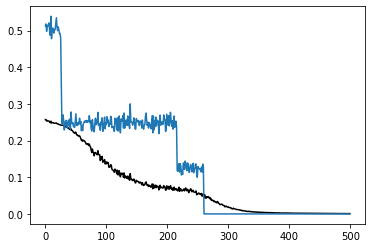

In [57]:
myRNN=RNNModel(8)
optimizer = optim.Adam(myRNN.parameters(), lr=0.003)#, momentum=0.9) #,weight_decay=0.001) #weight_decay is L2 regularization, we don't want thsi here as it might mess with smearing
error = nn.MSELoss()

episodes=500

L=[]
C=[]
batches=1000
for episode in range(episodes):
    signal,target=dataGenerator(batches)
    optimizer.zero_grad()
    myRNN.resetToZero(batches)
    outputs,history = myRNN(signal.float())
    loss = error(outputs, target.float())
    L.append(float(loss))
    loss.backward()
    optimizer.step()
    if (episode%50)==0:
        print(episode,L[-1])
    o=1.0*(outputs.detach().numpy().reshape((batches))>0.5)
    t=target.detach().numpy().reshape((batches))
    c=abs(o-t).sum()/batches
    C.append(c)
plot(L,'k')
plot(C)

#uncomment only if you want to generate new data
#torch.save(myRNN.state_dict(), "RNN_example_{0}back_{1}nodes.model".format(nBack,6))

In [ ]:
#torch.save(myRNN.state_dict(), "RNN_suppModel.model".format(nBack,6))
#D=DataFrame()
#D["L"]=L
#D["C"]=C
#D.to_csv("RNN_suppModel_trainingData.csv")

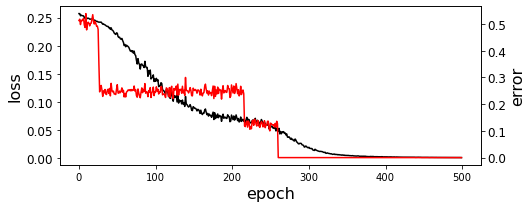

In [58]:
figure(figsize=[7.5,3])
plot(L,'k')
ylabel("loss",fontsize=16)
yticks(fontsize=12)
xlabel("epoch",fontsize=16)
twinx()
plot(C,'r')
ylabel("error",fontsize=16)
xticks(fontsize=12)
yticks(fontsize=12)
tight_layout()
savefig("sup_fitting.pdf")

In [60]:
def perfectDataSet(signal,M):
    for i in range(0,len(signal)):
        for j in range(12,20):
            M[i][j]=numpy.random.choice([0.0,1.0])
            
    for i in range(0,len(signal),4):
        M[i][12]=signal[i][0]
        M[i+1][12]=signal[i][0]
        M[i+2][12]=signal[i][0]
        M[i+3][12]=signal[i][0]
        
        M[i+1][13]=signal[i+1][1]
        M[i+2][13]=signal[i+1][1]
        M[i+3][13]=signal[i+1][1]
        
        M[i+2][14]=signal[i+2][2]
        M[i+3][14]=signal[i+2][2]
        
    return M

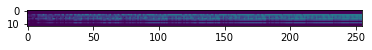

In [61]:

batches=1000
signal,target=dataGenerator(batches)
myRNN.resetToZero(batches)
outputs,history = myRNN(signal.float())
res=[]
for rep in [True,False]:
    M=numpy.zeros((batches*4,23))
    signal=signal.reshape((batches*4,3))
    for i in range(batches*4):
        for j in range(3):
            M[i][20+j]=signal[i][j] #sensor information

    for i in range(0,batches*4,4):
        M[i][0]=signal[i][0]
        M[i][1]=signal[i][1]
        M[i][2]=signal[i][2]

        M[i+1][0]=signal[i+1][0]
        M[i+1][1]=signal[i+1][1]
        M[i+1][2]=signal[i+1][2]
        M[i+1][3]=signal[i][0]
        M[i+1][4]=signal[i][1]
        M[i+1][5]=signal[i][2]

        M[i+2][0]=signal[i+2][0]
        M[i+2][1]=signal[i+2][1]
        M[i+2][2]=signal[i+2][2]
        M[i+2][3]=signal[i+1][0]
        M[i+2][4]=signal[i+1][1]
        M[i+2][5]=signal[i+1][2]
        M[i+2][6]=signal[i][0]
        M[i+2][7]=signal[i][1]
        M[i+2][8]=signal[i][2]

        M[i+3][0]=signal[i+3][0]
        M[i+3][1]=signal[i+3][1]
        M[i+3][2]=signal[i+3][2]
        M[i+3][3]=signal[i+2][0]
        M[i+3][4]=signal[i+2][1]
        M[i+3][5]=signal[i+2][2]
        M[i+3][6]=signal[i+1][0]
        M[i+3][7]=signal[i+1][1]
        M[i+3][8]=signal[i+1][2]
        M[i+3][9]=signal[i][0]
        M[i+3][10]=signal[i][1]
        M[i+3][11]=signal[i][2]


    for j in range(8):
        I=medianBinarizationVector(history.detach().numpy().reshape((batches*4,8)).transpose()[j])
        for i in range(batches*4):
            M[i][j+12]=I[i]
    if rep:
        M=perfectDataSet(signal,M)

    #M=M.transpose() #generated the whole thing in the right shape already, not needed
    hiddenPS=powerset([12,13,14,15,16,17,18,19])[1:]
    worldPS=[[0, 1, 2],[3, 4, 5],[6, 7, 8],[9, 10, 11],
             [0, 1, 2, 3, 4, 5],[0, 1, 2, 6, 7, 8],[0, 1, 2, 9, 10, 11],[3, 4, 5, 6, 7, 8],[3, 4, 5, 9, 10, 11],[6, 7, 8, 9, 10, 11],
             [0, 1, 2, 3, 4, 5, 6, 7, 8],[0, 1, 2, 3, 4, 5, 9, 10, 11],[0, 1, 2, 6, 7, 8, 9, 10, 11],[3, 4, 5, 6, 7, 8, 9, 10, 11],
             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    worldPS=powerset([0,1,2,3,4,5,6,7,8,9,10,11])
    worldPS=[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]
    resM=numpy.zeros((len(hiddenPS),len(worldPS)))

    S=extractBitPattern(M,[20,21,22])
    for w in worldPS:
        for h in hiddenPS:
            W=extractBitPattern(M,list(w))
            H=extractBitPattern(M,list(h))
            resM[hiddenPS.index(h)][worldPS.index(w)]=computeR(W,H,S)
    imshow(resM.transpose(),vmin=0.0,vmax=1.0)
    res.append(resM)
#ylim(0.5,14.5)

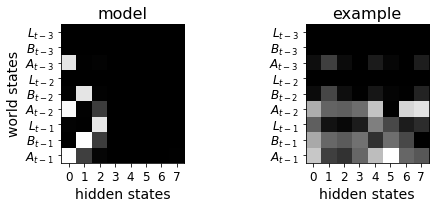

In [62]:
figure(figsize=[7.5,3])
subplot(1,2,1)
imshow(res[0][:8].transpose()[3:],cmap="gray")
yticks(range(12),[r"$A_{t-1}$",r"$B_{t-1}$",r"$L_{t-1}$",
                  r"$A_{t-2}$",r"$B_{t-2}$",r"$L_{t-2}$",r"$A_{t-3}$",r"$B_{t-3}$",r"$L_{t-3}$"],fontsize=12)
ylim(-0.5,8.5)
xticks(range(8),fontsize=12)
ylabel("world states",fontsize=14)
xlabel("hidden states",fontsize=14)
title("model",fontsize=16)

subplot(1,2,2)
imshow(res[1][:8].transpose()[3:],cmap="gray")
yticks(range(12),[r"$A_{t-1}$",r"$B_{t-1}$",r"$L_{t-1}$",
                  r"$A_{t-2}$",r"$B_{t-2}$",r"$L_{t-2}$",r"$A_{t-3}$",r"$B_{t-3}$",r"$L_{t-3}$"],fontsize=12)
ylim(-0.5,8.5)
xticks(range(8),fontsize=12)
xlabel("hidden states",fontsize=14)
title("example",fontsize=16)

tight_layout()
savefig("sup_comparison.pdf")

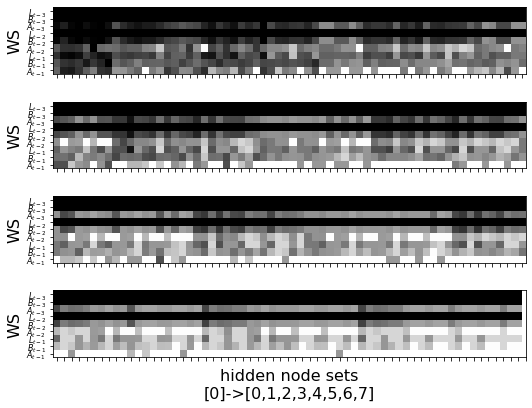

In [63]:
figure(figsize=[7.5,6])
for i in range(4):
    subplot(4,1,i+1)
    imshow(res[1][(64*i):(64*(i+1))].transpose()[3:],cmap="gray",vmax=res[1].max())
    yticks(range(12),[r"$A_{t-1}$",r"$B_{t-1}$",r"$L_{t-1}$",
                  r"$A_{t-2}$",r"$B_{t-2}$",r"$L_{t-2}$",r"$A_{t-3}$",r"$B_{t-3}$",r"$L_{t-3}$"],fontsize=8)
    ylim(-0.5,8.5)
    xticks(range(64),[""]*64)
    ylabel("WS",fontsize=16)
xlabel("hidden node sets\n[0]->[0,1,2,3,4,5,6,7]",fontsize=16)     
tight_layout()
savefig("sup_allStates.pdf")